<a href="https://colab.research.google.com/github/DanielhCarranza/CarcinomaClassifier/blob/master/Breast_Cancer_Carcinoma_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICIAR 2018
Breast cancer is one of the leading cancer-related death causes worldwide, specially on women. However, early diagnosis significantly increases treatment success. For the purpose of early diagnosis, proper analysis of histology images is essential. Specifically, during the diagnosis procedure, specialists evaluate both overall and local tissue organization via whole-slide and microscopy images. However, the large amount of data and complexity of the images makes this task time consuming and non-trivial. Because of this, the development of automatic detection and diagnosis tools is challenging but also essential for the field.

There are two goals in this challenge. The part A of the challenge consists in automatically classifying H&E stained breast histology microscopy images in four classes: normal, benign, in situ carcinoma and invasive carcinoma. The part B consists in performing pixel-wise labelling of whole-slide images in the same four classes. For these purposes, challenge participants will be provided with approx. 400+ labeled microscopy images, and 10 pixel-wise labeled and 20 non-labeled whole-slide images

## Dataset
The dataset is composed of Hematoxylin and eosin (H&E) stained breast histology microscopy and whole-slide images. Challenge participants should evaluate the performance of their method on either/both sets of images.

### Microscopy images 
Microscopy images are labelled as normal, benign, in situ carcinoma or invasive carcinoma according to the predominant cancer type in each image. The annotation was performed by two medical experts and images where there was disagreement were discarded.

![texto alternativo](https://iciar2018-challenge.grand-challenge.org/media/ICIAR2018-Challenge/public_html/benign.png/)

The dataset contains a total of 400 microscopy images, distributed as follows:

* Normal: 100
* Benign: 100
* in situ carcinoma: 100
* Invasive carcinoma: 100

Microscopy images are on .tiff format and have the following specifications:

* Color model: R(ed)G(reen)B(lue)
* Size: 2048 x 1536 pixels
* Pixel scale: 0.42 µm x 0.42 µm
/ Memory space: 10-20 MB (approx.)
* Type of label: image-wise


### Whole-slide images
Whole-slide images are high resolution images containing the entire sampled tissue. In this sense, microscopy images are just details of the whole-slide images. Because of that, each whole-slide image can have multiple **normal, benign, in situ carcinoma and invasive carcinoma** regions. The annotation of the whole-slide images was performed by two medical experts and images where there was disagreement were discarded. Each image has a corresponding list of labelled coordinates that enclose benign, in situ carcinoma and invasive carcinoma regions (the remaning tissue is considered normal and thus is not relevant for performance evaluation).
![texto alternativo](https://iciar2018-challenge.grand-challenge.org/media/ICIAR2018-Challenge/public_html/A08_thumb.png/)

Whole-slide images are on .svs format and have the following specifications:

* Color model: R(ed)G(reen)B(lue)
* Size: variable (eg: 42113 x 62625 pixels)
* Pixel scale: 0,467 µ/pixel
* Memory space: 8 GB (approx.) when in numpy array (pyhton), 200-250 MB (approx.) in .svs
* Acquisition system: Leica SCN400
* Type of label: pixel-wise


Annotations of the coordinates of the points that enclose each region are made avaliable as a .xml file.

#### References
* https://github.com/ImagingLab/ICIAR2018 

### Dataset

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.callbacks.mem import PeakMemMetric

import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc,roc_curve
from sklearn.metrics import classification_report


In [ ]:
path = Path('ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/')
path_test= Path('ICIAR2018_data/ICIAR2018_BACH_Challenge_TestDataset/Photos/')
path.ls()

[PosixPath('ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/microscopy_ground_truth.csv'),
 PosixPath('ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/InSitu'),
 PosixPath('ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/Normal'),
 PosixPath('ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/Benign'),
 PosixPath('ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/Invasive'),
 PosixPath('ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/models'),
 PosixPath('ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/.DS_Store')]

In [ ]:
classes = ['Normal', 'Benign', 'Invasive', 'InSitu']
classes = [f.parts[-1] for f in path.ls() if f.is_dir() and (f.parts[-1] in classes)]
classes

['InSitu', 'Normal', 'Benign', 'Invasive']

In [ ]:
class CancerImageList(ImageList):  
  def open(self,fn): 
    im = cv2.imread(str(fn))
    img = pil2tensor(PIL.Image.fromarray(im), np.float32)
    img= img.div_(255)
    return Image(img)
    

In [ ]:
get_labels = lambda x: x.parts[-2]

In [ ]:
src = (CancerImageList.from_folder(path)
       .split_by_rand_pct()
       .label_from_func(get_labels,classes=classes))

test_list = CancerImageList.from_folder(path_test)

In [ ]:
def get_data(bs,size):
  return (src.transform(tfms= get_transforms(flip_vert=True), size= size)
       .databunch(num_workers=4, bs= bs)       
       .normalize())

In [ ]:
data= get_data(64, 256)

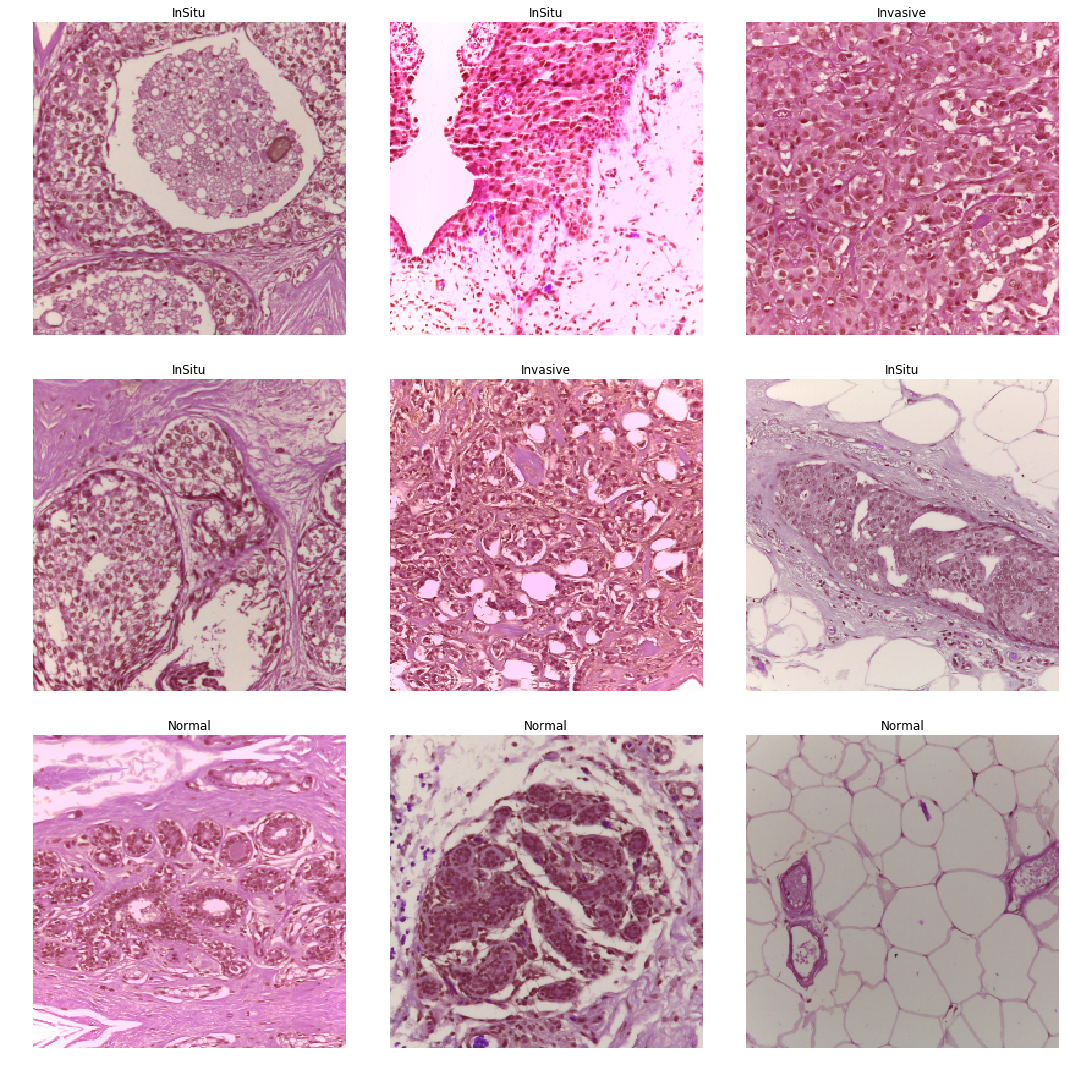

In [ ]:
data.show_batch(rows=3, figsize=(15,15))

## Training 

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='res34_256'),
        ShowGraph]

In [ ]:
learner= cnn_learner(data, models.resnet34, metrics= [accuracy], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:04, 20705079.14it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


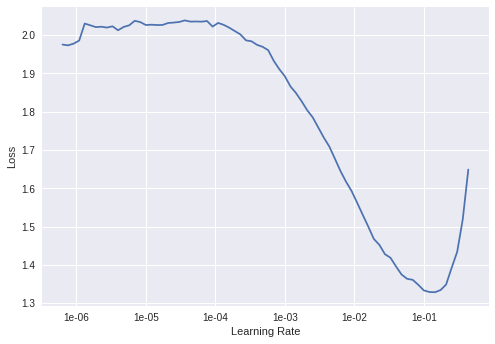

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr= 1e-2
learner.fit_one_cycle(8, slice(1e-3, 5*lr))

In [ ]:
learner.unfreeze()
# learner.lr_find()
# learner.recorder.plot()

In [ ]:
learner.save('stage-0')

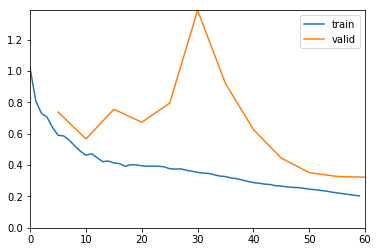

In [ ]:
lr= 1e-3
learner.fit_one_cycle(12, slice(1e-4,lr))  

In [ ]:
learner.save('stage-1')

#### Data 512

In [ ]:
data_512= get_data(64, 512)

In [ ]:
learner= cnn_learner(data_512, models.resnet34, metrics= [accuracy], callback_fns=[partial(SaveModelCallback,every='epoch',name='512'),
                                 ShowGraph]).load('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


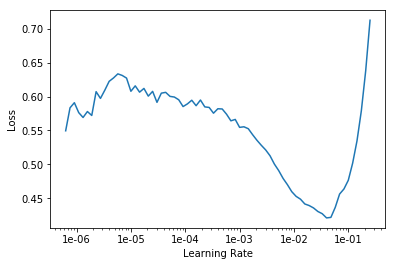

In [ ]:
learner.lr_find()
learner.recorder.plot()

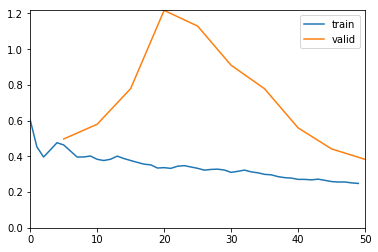

In [ ]:
lr= 1e-2
learner.fit_one_cycle(10, slice(1e-3, 5*lr))

In [ ]:
learner.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


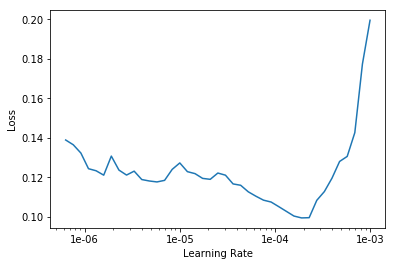

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

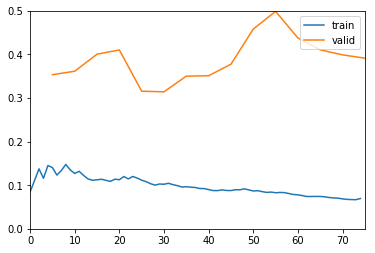

In [ ]:
lr= 1e-4
learner.fit_one_cycle(15, slice(1e-5,5*lr))

In [ ]:
learner.save('stage-3')

### Data 720

In [ ]:
data_720= get_data(32,720) 

In [ ]:
learner= cnn_learner(data_720, models.resnet34, metrics= [accuracy], callback_fns=[partial(SaveModelCallback,every='epoch',name='1'),
                                 ShowGraph]).load('stage-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


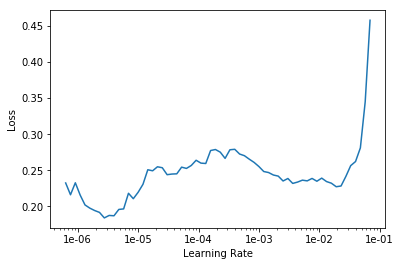

In [ ]:
learner.lr_find()
learner.recorder.plot()

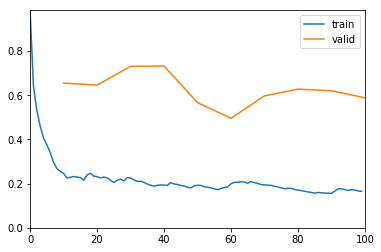

In [ ]:
lr= 1e-2
learner.fit_one_cycle(10, slice(1e-3, lr) )

In [ ]:
learner.save('stage-4')

In [ ]:
learner.unfreeze()
# learner.lr_find()
# learner.recorder.plot()

In [ ]:
# learner.load('stage-4')

In [ ]:
lr= 1e-4
learner.fit_one_cycle(15, slice(1e-5,lr))

In [ ]:
original_size= (1536, 2048)
learner.save('stage-5')

### Data 1024

In [ ]:
data_1024 = get_data(16, 1024)

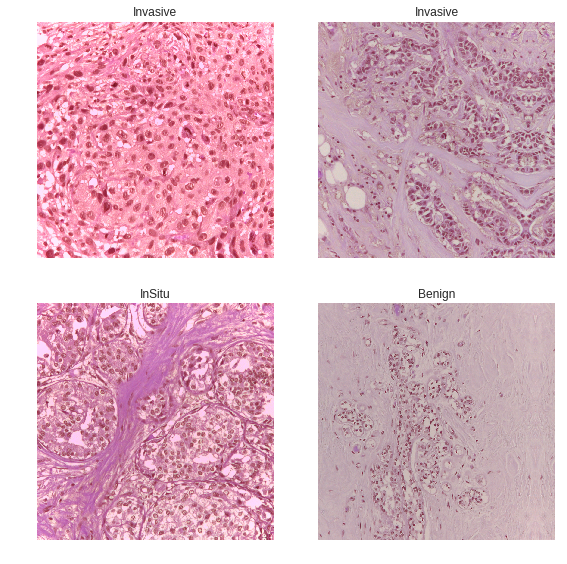

In [ ]:
data_1024.show_batch(rows=2)

In [ ]:
learner= cnn_learner(data_1024, models.resnet34, metrics= [accuracy], callback_fns=[partial(SaveModelCallback,every='epoch',name='2'),
                                 ShowGraph]).load('stage-5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


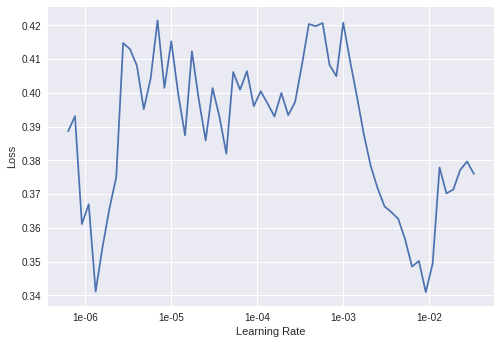

In [ ]:
learner.lr_find()
learner.recorder.plot()

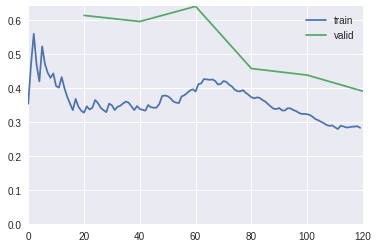

In [ ]:
lr= 1e-2
learner.fit_one_cycle(6, slice(1e-3, lr) )

In [ ]:
learner.save('stage-6')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


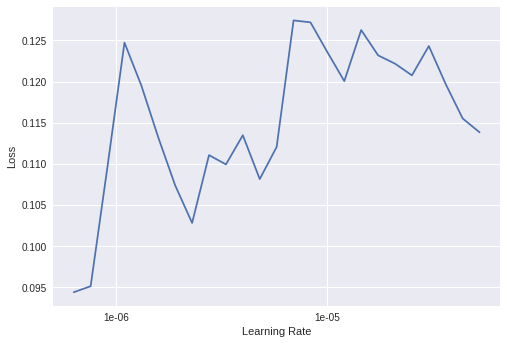

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

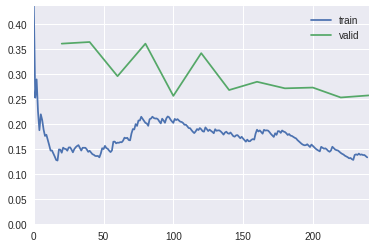

In [ ]:
lr= 1e-4
learner.fit_one_cycle(12, slice(1e-5,lr))

In [ ]:
learner.save('stage-7') # 2_8.pth --> best model 

### Save model

In [ ]:
ls data/ICIAR2018_BACH_Challenge/Photos/models/

1_0.pth     512_11.pth  512_8.pth      origin_4.pth   res50_512-1.pth
1_10.pth    512_12.pth  512_9.pth      origin_5.pth   res50_512-2.pth
1_11.pth    512_13.pth  origin_0.pth   origin_6.pth   res50_5.pth
1_1.pth     512_14.pth  origin_10.pth  origin_7.pth   res50_6.pth
1_2.pth     512_15.pth  origin_11.pth  origin_8.pth   res50_7.pth
1_3.pth     512_16.pth  origin_12.pth  origin_9.pth   res50_8.pth
1_4.pth     512_17.pth  origin_13.pth  res50_0.pth    res50_9.pth
1_5.pth     512_1.pth   origin_14.pth  res50_10.pth   stage-0.pth
1_6.pth     512_2.pth   origin_15.pth  res50_11.pth   stage-1.pth
1_7.pth     512_3.pth   origin_16.pth  res50_1.pth    stage-2.pth
1_8.pth     512_4.pth   origin_17.pth  res50_256.pth  stage-3.pth
1_9.pth     512_5.pth   origin_1.pth   res50_2.pth    stage-4.pth
512_0.pth   512_6.pth   origin_2.pth   res50_3.pth    tmp.pth
512_10.pth  512_7.pth   origin_3.pth   res50_4.pth


## Evaluation

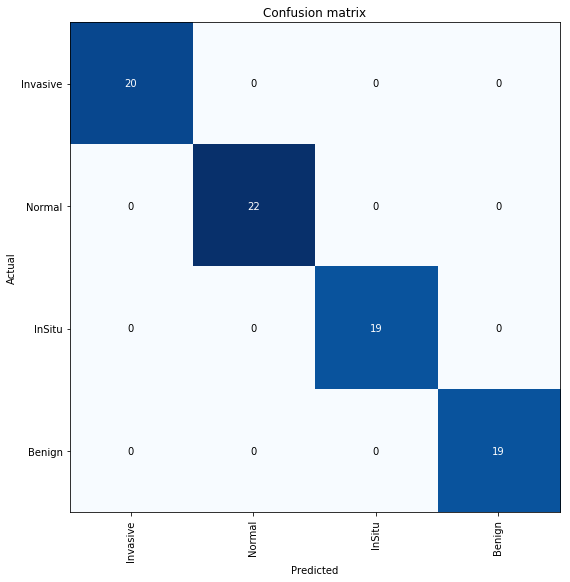

In [ ]:
conf= ClassificationInterpretation.from_learner(learner)
conf.plot_confusion_matrix(figsize=(10,8))

In [ ]:
# Predictions of the validation data
preds_val, y_val=learner.get_preds()

In [ ]:
from sklearn.metrics import auc,roc_curve

In [ ]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(y_val.numpy(), preds_val.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

ROC area is 0.24503882657463333


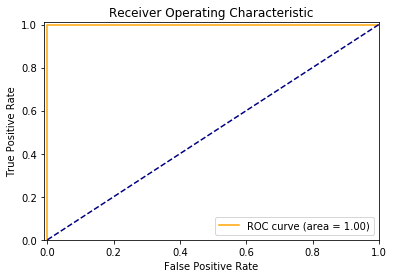

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Data Original size 

In [ ]:
original_size= (1536, 2048)
size=(1512,1512) 

In [ ]:
data_origin= get_data(4, size=size)

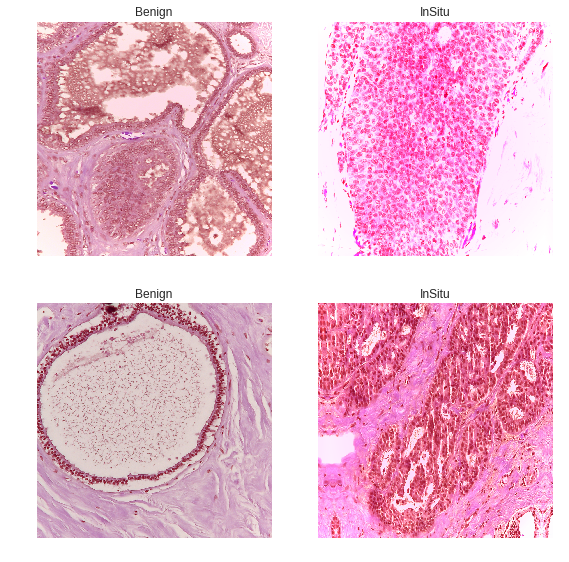

In [ ]:
data_origin.show_batch(rows=2)

In [ ]:
learner= cnn_learner(data_origin, models.resnet34, metrics= [accuracy], callback_fns=[partial(SaveModelCallback, every='epoch',name='o'),
                                 ShowGraph])

In [ ]:
learner.load('2_8')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


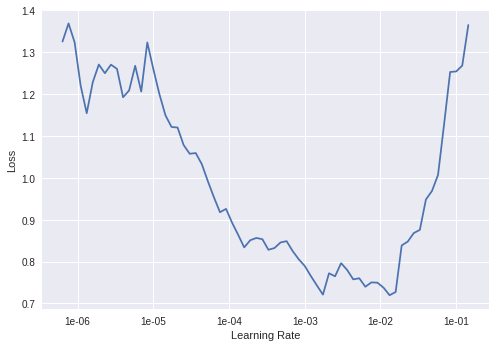

In [ ]:
learner.lr_find()
learner.recorder.plot()

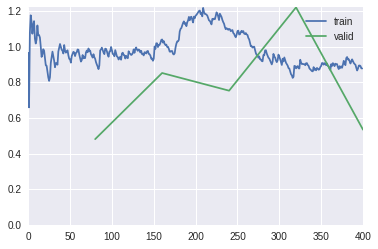

In [ ]:
lr= 1e-2
learner.fit_one_cycle(15, slice(1e-3, lr))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


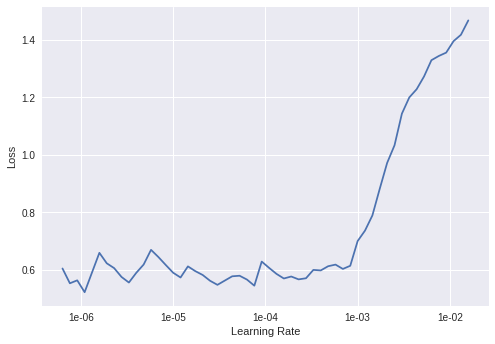

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr= 1e-4
learner.fit_one_cycle(16, slice(1e-5,5*lr))

## Resnet50

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='res50_256'),
        ShowGraph]

In [ ]:
learner= cnn_learner(data, models.resnet50, metrics= [accuracy], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 103628893.40it/s]


In [ ]:
learner.lr_find()
learner.recorder.plot()

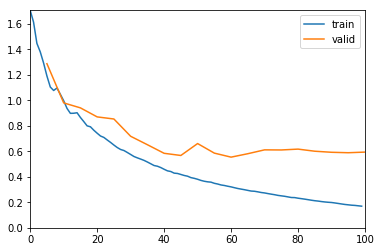

Epoch 9: reducing lr to 0.0016234913078995265
Epoch 10: reducing lr to 0.001433886003582602
Epoch 12: reducing lr to 0.0010000040000000003
Epoch 13: reducing lr to 0.0007774839561274217
Epoch 14: reducing lr to 0.0005661219964173986
Epoch 15: reducing lr to 0.00037651669210047407
Epoch 16: reducing lr to 0.00021817564485790013
Epoch 17: reducing lr to 9.90387359730526e-05
Epoch 18: reducing lr to 2.5079987529825117e-05
Epoch 19: reducing lr to 8.000000000000002e-09


In [ ]:
lr= 1e-1
learner.fit_one_cycle(20, slice(1e-3,1e-2, lr))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


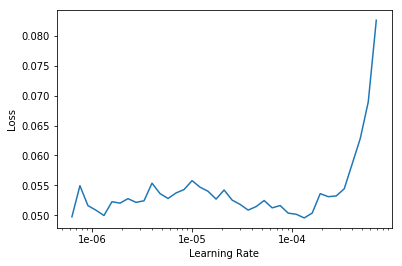

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

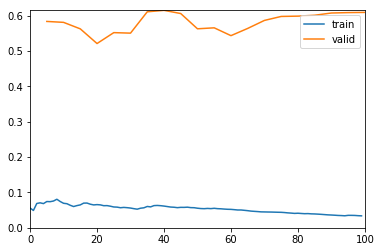

Epoch 4: reducing lr to 5.614153162899184e-05
Epoch 5: reducing lr to 6.000000000000001e-05
Epoch 6: reducing lr to 5.9247840374105255e-05
Epoch 7: reducing lr to 5.7029077920808436e-05
Epoch 8: reducing lr to 5.3454970654263e-05
Epoch 9: reducing lr to 4.87047392369858e-05
Epoch 10: reducing lr to 4.3016580107478055e-05
Epoch 11: reducing lr to 3.6675721316177365e-05
Epoch 12: reducing lr to 3.0000120000000006e-05
Epoch 13: reducing lr to 2.332451868382265e-05
Epoch 14: reducing lr to 1.6983659892521956e-05
Epoch 15: reducing lr to 1.1295500763014222e-05
Epoch 16: reducing lr to 6.545269345737004e-06
Epoch 17: reducing lr to 2.9711620791915775e-06
Epoch 18: reducing lr to 7.523996258947534e-07
Epoch 19: reducing lr to 2.4000000000000005e-10


In [ ]:
lr= 1e-4
learner.fit_one_cycle(20, slice(1e-5,3*lr)) 

In [ ]:
learner.save('res50_256-92acc')

In [ ]:
ls CancerData/data/ICIAR2018_BACH_Challenge/Photos/models/

res50_0.pth       res50_256_1.pth   res50_256_30.pth  res50_256_41.pth
res50_256_0.pth   res50_256_20.pth  res50_256_31.pth  res50_256_42.pth
res50_256_10.pth  res50_256_21.pth  res50_256_32.pth  res50_256_43.pth
res50_256_11.pth  res50_256_22.pth  res50_256_33.pth  res50_256_4.pth
res50_256_12.pth  res50_256_23.pth  res50_256_34.pth  res50_256_5.pth
res50_256_13.pth  res50_256_24.pth  res50_256_35.pth  res50_256_6.pth
res50_256_14.pth  res50_256_25.pth  res50_256_36.pth  res50_256_7.pth
res50_256_15.pth  res50_256_26.pth  res50_256_37.pth  res50_256_8.pth
res50_256_16.pth  res50_256_27.pth  res50_256_38.pth  res50_256-92acc.pth
res50_256_17.pth  res50_256_28.pth  res50_256_39.pth  res50_256_9.pth
res50_256_18.pth  res50_256_29.pth  res50_256_3.pth   res50_256.pth
res50_256_19.pth  res50_256_2.pth   res50_256_40.pth  tmp.pth


In [ ]:
data_512= get_data(24, 512)

In [ ]:
learner= cnn_learner(data_512, models.resnet50, metrics= [accuracy], 
                     callback_fns=cbfs).load('res50_256-92acc') 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


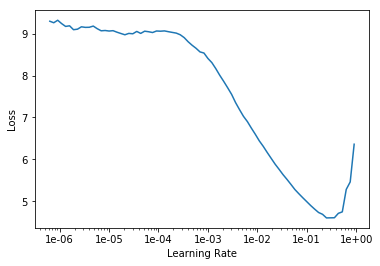

In [ ]:
learner.lr_find()
learner.recorder.plot()

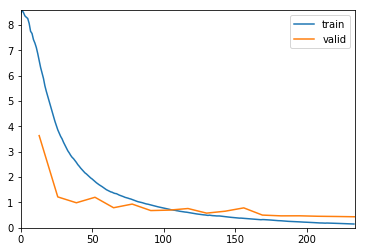

Epoch 3: reducing lr to 0.0017034201430273903
Epoch 5: reducing lr to 0.001988280470658654
Epoch 7: reducing lr to 0.0017952936901019416
Epoch 8: reducing lr to 0.0016213494409333378
Epoch 10: reducing lr to 0.0011715549853392924
Epoch 11: reducing lr to 0.0009234550533605157
Epoch 14: reducing lr to 0.00026633491912644375


In [ ]:
lr= 1e-2
learner.fit_one_cycle(18, lr)

In [ ]:
learner.save('res50_512-1')

In [ ]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


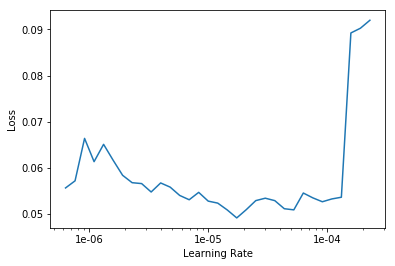

In [ ]:
learner.lr_find()
learner.recorder.plot()


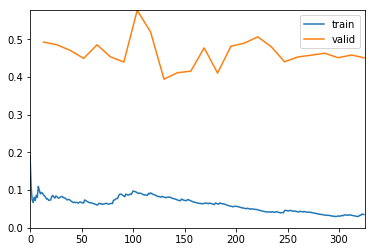

Epoch 4: reducing lr to 1.5289473558356126e-05
Epoch 5: reducing lr to 1.8239011165349233e-05
Epoch 7: reducing lr to 1.9953520902860512e-05
Epoch 8: reducing lr to 1.96226815123725e-05
Epoch 10: reducing lr to 1.8057658826005564e-05
Epoch 11: reducing lr to 1.687355685951718e-05
Epoch 12: reducing lr to 1.5469499703297953e-05
Epoch 13: reducing lr to 1.389041772771011e-05
Epoch 14: reducing lr to 1.2186842164820114e-05
Epoch 15: reducing lr to 1.0413288089489164e-05
Epoch 16: reducing lr to 8.626509915958233e-06
Epoch 17: reducing lr to 6.883685234709515e-06
Epoch 18: reducing lr to 5.240585107524988e-06
Epoch 19: reducing lr to 3.7497893720057336e-06
Epoch 20: reducing lr to 2.4590040664954306e-06
Epoch 21: reducing lr to 1.4095348184593224e-06
Epoch 22: reducing lr to 6.349650484791016e-07
Epoch 23: reducing lr to 1.600812878454892e-07
Epoch 24: reducing lr to 8.000000000000003e-11


In [ ]:
lr= 1e-4
learner.fit_one_cycle(25, slice(1e-5,lr)) 

In [ ]:
learner.save('res50_512-2')

#### 720

In [ ]:
data_720 = get_data(8, 720)

In [ ]:
learner= cnn_learner(data_720, models.resnet50, metrics= [accuracy], 
                     callback_fns=cbfs).load('res50_512-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


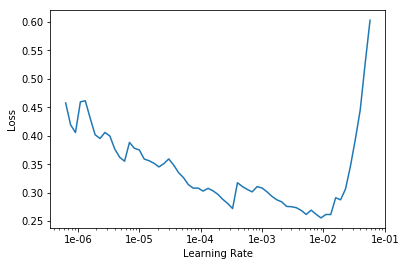

In [ ]:
learner.lr_find()
learner.recorder.plot()


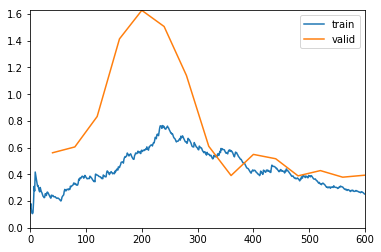

Epoch 1: reducing lr to 0.0008732977494397469
Epoch 2: reducing lr to 0.0015200000000000003
Epoch 3: reducing lr to 0.0019421049159544725
Epoch 4: reducing lr to 0.001988830870901824
Epoch 5: reducing lr to 0.0019009692640269478
Epoch 6: reducing lr to 0.0017330529396223393
Epoch 7: reducing lr to 0.0015000020000000003
Epoch 9: reducing lr to 0.0009252742053339503
Epoch 10: reducing lr to 0.0006346644369977026
Epoch 12: reducing lr to 0.00017376853063910263
Epoch 14: reducing lr to 8.000000000000002e-09


In [ ]:
lr= 1e-2
learner.fit_one_cycle(15, slice(1e-3, lr))

In [ ]:
learner.save('res50_720-1')

In [ ]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


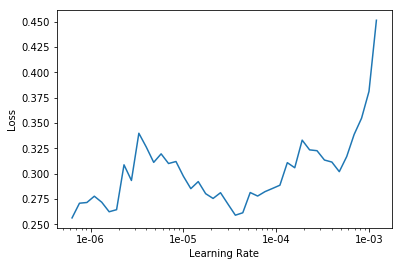

In [ ]:
learner.lr_find()
learner.recorder.plot()

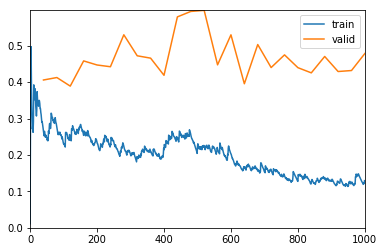

Epoch 1: reducing lr to 3.976346178954961e-06
Epoch 3: reducing lr to 1.1403473247369475e-05
Epoch 4: reducing lr to 1.5200000000000004e-05
Epoch 5: reducing lr to 1.8166563145999503e-05
Epoch 6: reducing lr to 1.9790216967044542e-05
Epoch 7: reducing lr to 1.995974310098064e-05
Epoch 8: reducing lr to 1.9639630048444114e-05
Epoch 9: reducing lr to 1.900969264026948e-05
Epoch 10: reducing lr to 1.8090177583069704e-05
Epoch 11: reducing lr to 1.6910638847362695e-05
Epoch 12: reducing lr to 1.550898777864177e-05
Epoch 13: reducing lr to 1.3930274595537976e-05
Epoch 14: reducing lr to 1.222524043872579e-05
Epoch 15: reducing lr to 1.044868650891194e-05
Epoch 16: reducing lr to 8.657712711154085e-06
Epoch 17: reducing lr to 6.909882416930305e-06
Epoch 18: reducing lr to 5.261372330016515e-06
Epoch 19: reducing lr to 3.7651669210047406e-06
Epoch 20: reducing lr to 2.469355462822532e-06
Epoch 21: reducing lr to 1.4155864019330836e-06
Epoch 22: reducing lr to 6.377287429974538e-07
Epoch 23: r

In [ ]:
lr= 1e-4
learner.fit_one_cycle(25, slice(1e-5,lr)) 

In [ ]:
learner.save('res50_720-90acc')

#### 1024

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='res50_1024'),
        ShowGraph]

In [ ]:
data_1024= get_data(4,1024)

In [ ]:
learner= cnn_learner(data_1024, models.resnet50, metrics= [accuracy], 
                     callback_fns=cbfs).load('res50_1024_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


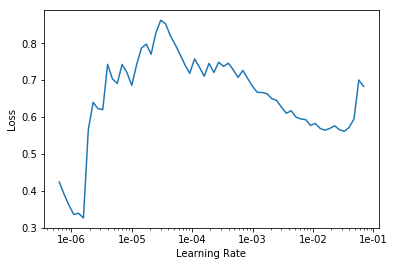

In [ ]:
learner.lr_find()
learner.recorder.plot()

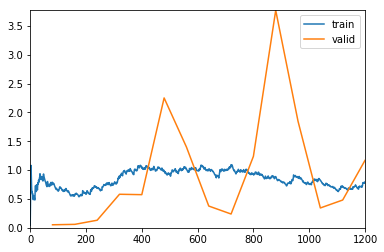

Epoch 1: reducing lr to 0.0008732977494397469
Epoch 2: reducing lr to 0.0015200000000000003
Epoch 3: reducing lr to 0.0019421049159544725
Epoch 4: reducing lr to 0.001988830870901824
Epoch 5: reducing lr to 0.0019009692640269478
Epoch 6: reducing lr to 0.0017330529396223393
Epoch 7: reducing lr to 0.0015000020000000003
Epoch 8: reducing lr to 0.0012225240438725788
Epoch 9: reducing lr to 0.0009252742053339503
Epoch 10: reducing lr to 0.0006346644369977026
Epoch 11: reducing lr to 0.00037651669210047407
Epoch 12: reducing lr to 0.00017376853063910263
Epoch 13: reducing lr to 4.443501650508237e-05
Epoch 14: reducing lr to 8.000000000000002e-09


In [ ]:
lr= 1e-2
learner.fit_one_cycle(15, slice(1e-3, lr))

In [ ]:
learner.load('res50_1024_1')

In [ ]:
# learner.save('res50_1024-98acc')
learner.export(file='models/breast_cancer_1024-98acc.pkl')

In [ ]:
stage_file='res50_1024_1.pth'
model_file='breast_cancer_1024-98acc.pkl'
path_local_models=(path/'models')
model_local_path=str(path_local_models/model_file)
# upload_files_to_gcp(model_local_path, path_models+'BreastCancer_models/ICIAR_2018/')
download_files_from_gcp(path_models+'BreastCancer_models/ICIAR_2018/'+model_file, path_local_models)


Copying gs://medbotai/models/BreastCancer_models/ICIAR_2018/breast_cancer_1024-98acc.pkl...
| [1/1 files][ 98.1 MiB/ 98.1 MiB] 100% Done                                    
Operation completed over 1 objects/98.1 MiB.                                     


In [ ]:
learner= load_learner(path_local_models, file='breast_cancer_1024-98acc.pkl')

In [ ]:
classes = learner.data.valid_ds.y.classes

src = (CancerImageList.from_folder(path)
       .split_by_rand_pct()
       .label_from_func(get_labels,classes=classes))

data_1024= get_data(4,1024)
learner.data=data_1024

### Evaluation

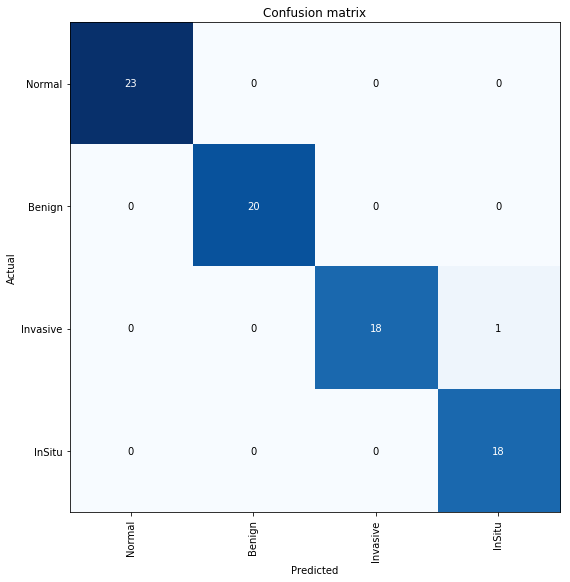

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
# Predictions of the validation data
preds, y_true=learner.get_preds()
y_true.shape, preds.shape

(torch.Size([80]), torch.Size([80, 4]))

In [ ]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((80,), (80,))

In [ ]:
# Generate a classification report
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        23
      Benign       1.00      1.00      1.00        20
    Invasive       1.00      0.95      0.97        19
      InSitu       0.95      1.00      0.97        18

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



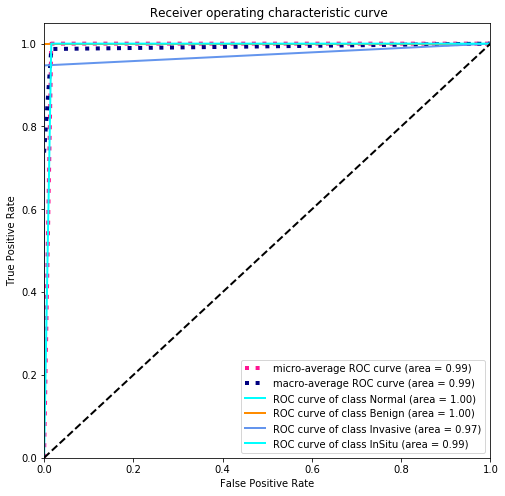

In [ ]:
from scipy import interp
from itertools import cycle


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for c,i, color in zip(classes,range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(c, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

Average precision score, micro-averaged over all classes: 0.98


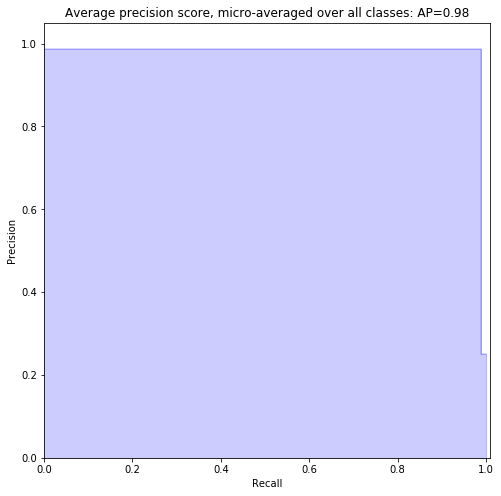

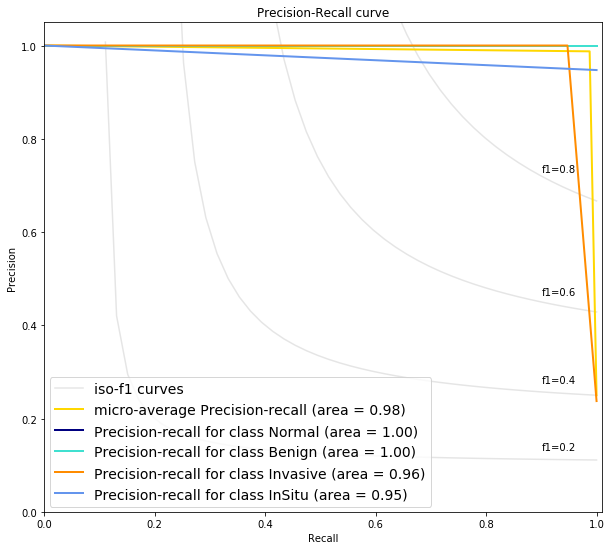

In [ ]:
from sklearn.metrics import precision_recall_curve,average_precision_score
from inspect import signature


def pr_curve(Y_test,y_score, classes, micro=True,isof1=True):
  precision = dict()
  recall = dict()
  average_precision = dict()
  n_classes=len(classes)
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                          y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
      y_score.ravel())
  average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                       average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))
  
  if micro:
    plt.figure(figsize=(8, 8))
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                     **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.01])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))
    
  if isof1:
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    for c,i, color in zip(classes,range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(c, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.2)
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(lines, labels, loc=(0.01, 0.01), prop=dict(size=14))
  
pr_curve(np.array(pd.get_dummies(y_true)), np.array(pd.get_dummies(preds)), classes)
  

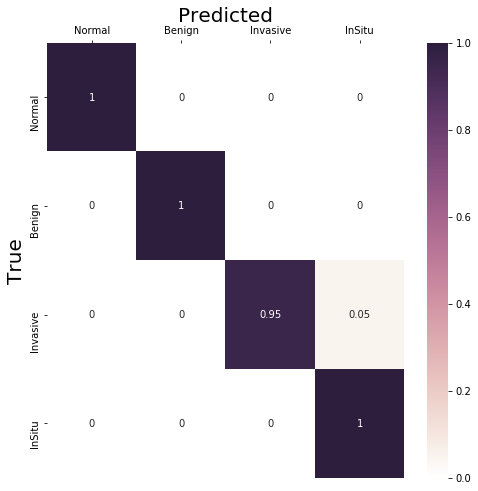

In [ ]:
from sklearn.metrics import confusion_matrix
# classes= ['Normal', 'Benign', 'Invasive', 'InSitu']
def plot_confusion_matrix(y_true, preds,classes, normalize=True):
  cm= confusion_matrix(y_true, preds)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
  _,ax=plt.subplots(figsize=(8,8))
  sns.heatmap(cm, annot=True, ax=ax, fmt = 'g', cmap=sns.cubehelix_palette(light=1, as_cmap=True))
  ax.set_xlabel('Predicted', fontsize=20)
  ax.xaxis.set_label_position('top') 
  ax.xaxis.set_ticklabels(classes)
  ax.xaxis.tick_top()
  ax.set_ylabel('True', fontsize=20)
  ax.yaxis.set_ticklabels(classes)
  
  
plot_confusion_matrix(y_true,preds,classes)

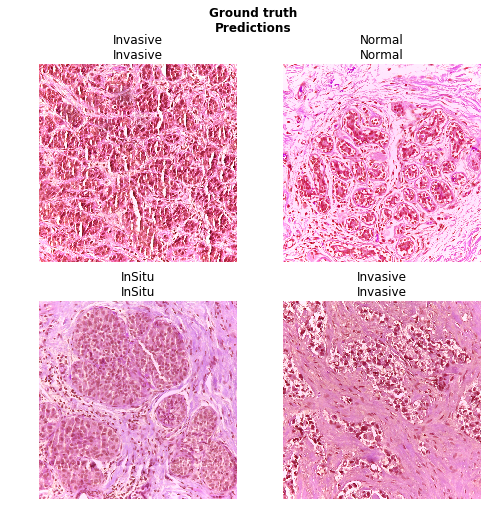

In [ ]:
learner.show_results()

#### Espanol

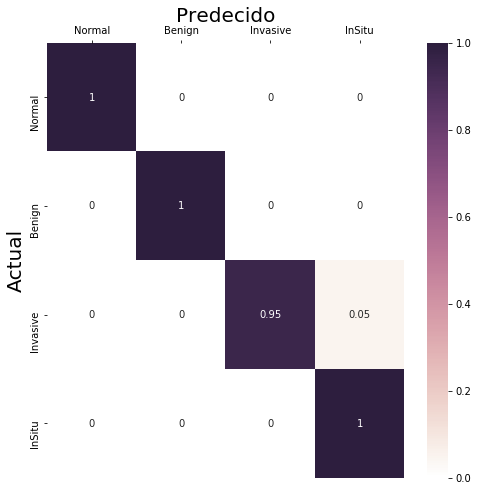

In [ ]:
from sklearn.metrics import confusion_matrix
# classes= ['Normal', 'Benign', 'Invasive', 'InSitu']
def plot_confusion_matrix(y_true, preds,classes, normalize=True):
  cm= confusion_matrix(y_true, preds)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
  _,ax=plt.subplots(figsize=(8,8))
  sns.heatmap(cm, annot=True, ax=ax, fmt = 'g', cmap=sns.cubehelix_palette(light=1, as_cmap=True))
  ax.set_xlabel('Predecido', fontsize=20)
  ax.xaxis.set_label_position('top') 
  ax.xaxis.set_ticklabels(classes)
  ax.xaxis.tick_top()
  ax.set_ylabel('Actual', fontsize=20)
  ax.yaxis.set_ticklabels(classes)
  
  
plot_confusion_matrix(y_true,preds,classes)

In [ ]:
classes

['Normal', 'Benign', 'Invasive', 'InSitu']

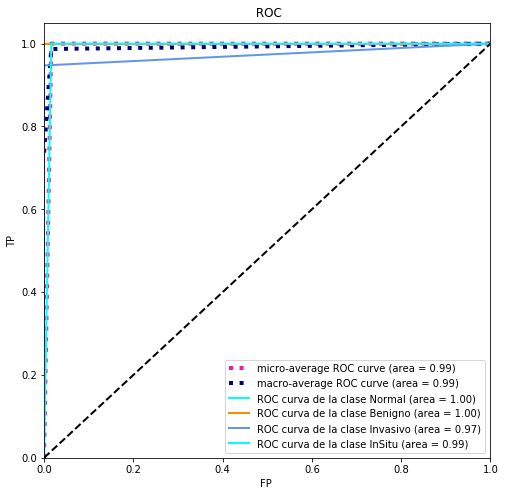

In [ ]:
from scipy import interp
from itertools import cycle


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
clase= ['Normal','Benigno','Invasivo','InSitu']
n_classes=len(clase)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for c,i, color in zip(clase,range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curva de la clase {0} (area = {1:0.2f})'
             ''.format(c, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP ')
plt.ylabel('TP')
plt.title(' ROC')
plt.legend(loc="lower right")
plt.show()

Average precision score, micro-averaged over all classes: 0.98


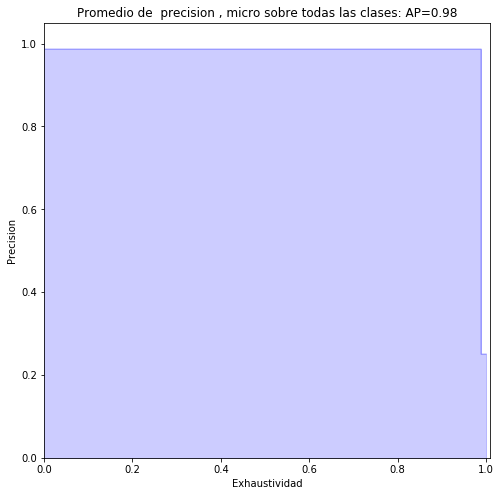

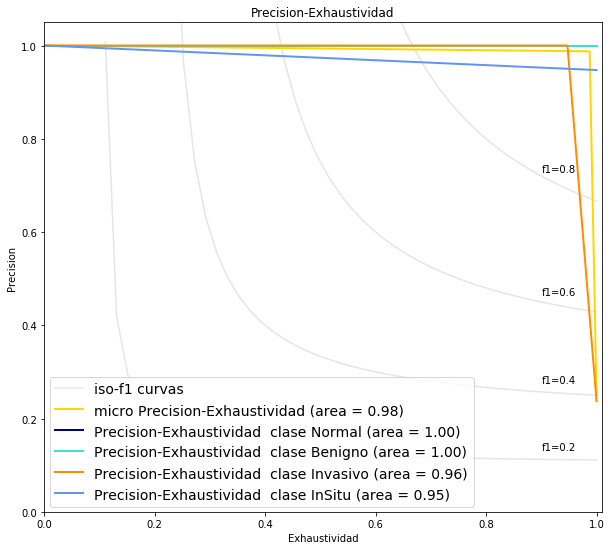

In [ ]:

def pr_curve(Y_test,y_score, classes, micro=True,isof1=True):
  precision = dict()
  recall = dict()
  average_precision = dict()
  n_classes=len(classes)
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                          y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
      y_score.ravel())
  average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                       average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))
  
  if micro:
    plt.figure(figsize=(8, 8))
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                     **step_kwargs)

    plt.xlabel('Exhaustividad')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.01])
    plt.title(
        'Promedio de  precision , micro sobre todas las clases: AP={0:0.2f}'
        .format(average_precision["micro"]))
    
  if isof1:
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curvas')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro Precision-Exhaustividad (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    for c,i, color in zip(classes,range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-Exhaustividad  clase {0} (area = {1:0.2f})'
                      ''.format(c, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.2)
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Exhaustividad')
    plt.ylabel('Precision')
    plt.title('Precision-Exhaustividad')
    plt.legend(lines, labels, loc=(0.01, 0.01), prop=dict(size=14))
  
pr_curve(np.array(pd.get_dummies(y_true)), np.array(pd.get_dummies(preds)), clase)

### Inference

In [ ]:
learner.export(file='models/breast_cancer_720-90acc.pkl')

In [ ]:
class Inference():
  def __init__(self, path, file_name): 
    """ Inference 
    :path = path to the .pkl file
    :file_name
    return: class prediction
    """
    self.learner=load_learner(path, file_name)
    self.learner.model.float()
  
  def __call__(self, img):
    img=open_img(img) if not isinstance(img,fastai.vision.image.Image ) else img
    pred_class, idx, probs= self.learner.predict(img)
    return pred_class,idx, probs

In [ ]:
model_file= 'breast_cancer_720-90acc.pkl'
# model_file= 'res50_720-90acc.pth'
path_local_models=(path/'models')
model_local_path=str(path_local_models/model_file)
# upload_files_to_gcp(model_local_path, path_models+'BreastCancer_models/ICIAR_2018/')
# download_files_from_gcp(path_models+'BreastCancer_models/ICIAR_2018/'+model_file, path_local_models)

In [ ]:
print(img_f)
from google.colab import files
files.download(str(img_f))

CancerData/data/ICIAR2018_BACH_Challenge/Photos/Benign/b090.tif


In [ ]:
predict_img= Inference(path_local_models, model_file)

In [ ]:
def open_img(fn): 
  im = cv2.imread(str(fn))
  img = pil2tensor(PIL.Image.fromarray(im), np.float32)
  img= img.div_(255)
  return Image(img)


img_f= (path/'Benign').ls()[0]
print(img_f.parts[-2])
img = open_img(img_f)

In [ ]:
predict_img(img)


(Category Benign,
 tensor(1),
 tensor([2.1970e-04, 9.7273e-01, 1.0837e-03, 2.5969e-02]))

In [ ]:
# path_model='ICIAR2018_data/ICIAR2018_BACH_Challenge/Photos/'
# stage_model='res50_1024_1.pth'
# model_file='breast_cancer_1024-98acc.pkl'

In [ ]:
# ls_gcp(path_models+'BreastCancer_models/ICIAR_2018/')

In [ ]:
# download_files_from_gcp(path_models+'BreastCancer_models/ICIAR_2018/breast_cancer_1024-98acc.pkl', path_model+'models/')

## Pruebas


In [ ]:
learnerInf= load_learner(path_model+'models/', file='breast_cancer_1024-98acc.pkl')

In [ ]:
learnerInf.data.valid_ds.y.classes



['Normal', 'Benign', 'Invasive', 'InSitu']

In [ ]:
learnerInf.data.single_ds.y.classes

['Normal', 'Benign', 'Invasive', 'InSitu']

In [ ]:
print(data_1024.train_ds[0])
img=data_1024.train_ds[0][0]

learnerInf.data=data_1024

(Image (3, 1024, 1024), Category Normal)


In [ ]:
# learner.data.train_ds.y.classes=['Normal', 'Benign', 'Invasive', 'InSitu']
learner.data.valid_ds.y.classes=['Invasive',   'Normal','Benign',  'InSitu']
learner.data.valid_ds.y.c2i={'Benign': 3, 'InSitu': 0, 'Invasive': 2, 'Normal': 1}
learner.data.valid_ds.y.c2i
# classes=['Normal', 'Benign', 'Invasive', 'InSitu']

{'Benign': 3, 'InSitu': 0, 'Invasive': 2, 'Normal': 1}

In [ ]:
learnerInf.predict(img)

(Category Normal,
 tensor(1),
 tensor([1.4875e-04, 5.9179e-01, 2.0097e-03, 4.0605e-01]))

In [ ]:
ClassificationInterpretation??

In [ ]:
interp = ClassificationInterpretation.from_learner(learnerInf)
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
# learner= cnn_learner(data_720, models.resnet50, metrics= [accuracy], callback_fns=[partial(SaveModelCallback, every='epoch',name='res50'),
#                                  ShowGraph])

In [ ]:
preds, y_true=learnerInf.get_preds()
y_true.shape, preds.shape

(torch.Size([80]), torch.Size([80, 4]))

In [ ]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((80,), (80,))

In [ ]:
report = classification_report(y_true, p.values, target_names=classes)
print(report)

              precision    recall  f1-score   support

      InSitu       0.90      1.00      0.95        18
    Invasive       1.00      1.00      1.00        21
      Normal       1.00      1.00      1.00        20
      Benign       1.00      0.90      0.95        21

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



In [ ]:
confusion_matrix??

In [ ]:
for i in range(len(y_true)):
  print(f"{preds[i]}  {y_true[i]} ")

In [ ]:
preds=pd.Series(preds).map({1:3, 3:0,2:1, 0:2})

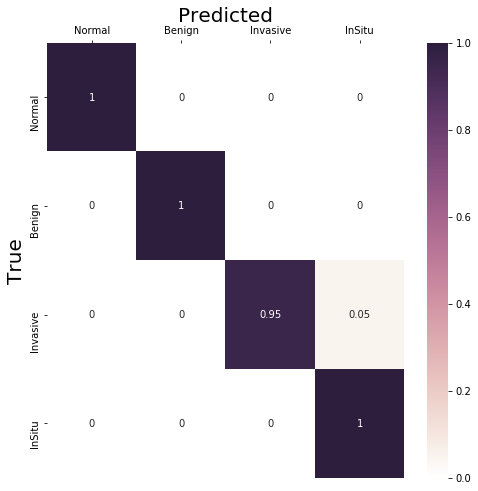

In [ ]:
from sklearn.metrics import confusion_matrix
# classes= ['Normal', 'Benign', 'Invasive', 'InSitu']
def plot_confusion_matrix(y_true, preds,classes):
  cm= confusion_matrix(y_true, preds)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
  _,ax=plt.subplots(figsize=(8,8))
  sns.heatmap(cm, annot=True, ax=ax, fmt = 'g', cmap=sns.cubehelix_palette(light=1, as_cmap=True))
  ax.set_xlabel('Predicted', fontsize=20)
  ax.xaxis.set_label_position('top') 
  ax.xaxis.set_ticklabels(classes)
  ax.xaxis.tick_top()
  ax.set_ylabel('True', fontsize=20)
  ax.yaxis.set_ticklabels(classes)
  
  
plot_confusion_matrix(y_true,preds,classes)

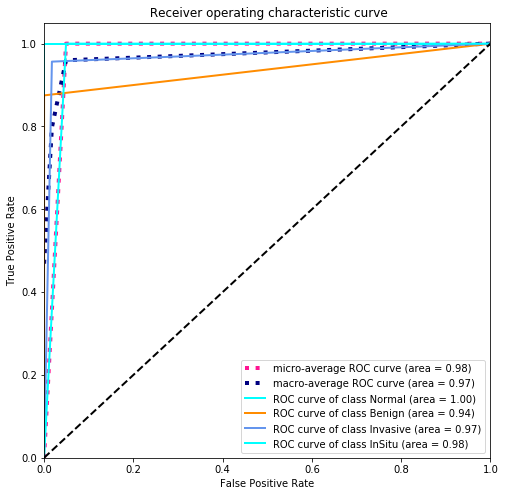

In [ ]:
from scipy import interp
from itertools import cycle


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for c,i, color in zip(classes,range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(c, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


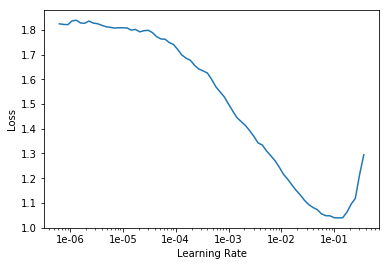

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='resp'),
        ShowGraph]
learner= cnn_learner(data, models.resnet50, metrics= [accuracy], callback_fns=cbfs)

learner.lr_find()
learner.recorder.plot()

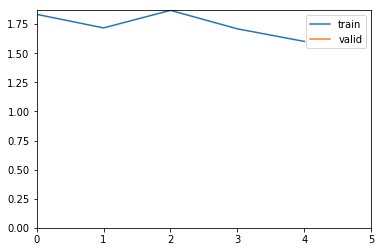

In [ ]:
lr= 1e-2
learner.fit_one_cycle(1, slice(1e-3, 5*lr))